In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
data= pd.read_csv('Lesson13.csv')
data.head()

,Total_bill,Tip,Sex,Smoker,Day,Time,Size,Tax
0,16.99,1.01,Female,No,Sun,Dinner,2,1.699
1,10.34,1.66,Male,No,Sun,Dinner,3,1.034
2,21.01,3.50,Male,No,Sun,Dinner,3,2.101
3,23.68,3.31,Male,No,Sun,Dinner,2,2.368
4,24.59,3.61,Female,No,Sun,Dinner,4,2.459


# データの正規性
これまで、母集団が正規分布に従うと仮定したら…という話を繰り返ししてきました。しかし、たとえ正規分布に従うべき変数を取り扱っていたとしても実際にサンプリングされたデータは正規分布らしくなく、歪んでいる場合があります。下記の図では分布が左側に偏っていますね。

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


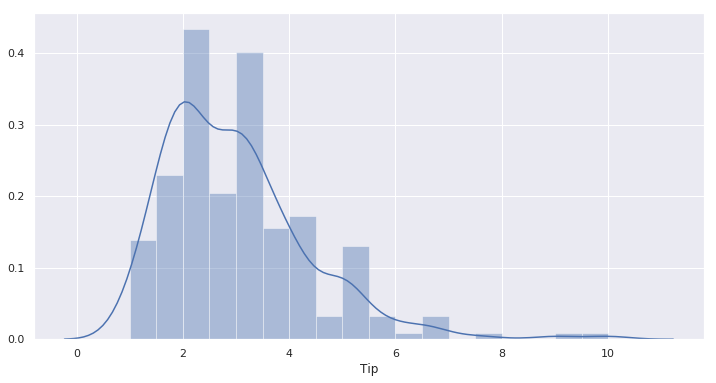

In [3]:
f, ax=plt.subplots(figsize=(12,6))
sns.distplot(data['Tip'])

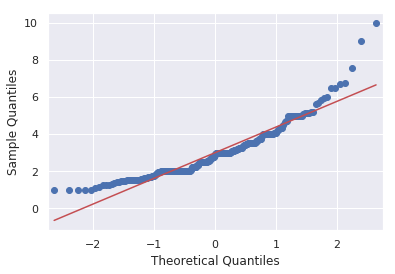

In [4]:
fig= sm.qqplot(data['Tip'], line='s')

# Log Transformation（対数変換）

In [5]:
# NumPyのlog1pを用いて、データの対A数変換を実施
data['Tip'] = np.log1p(data['Tip'])

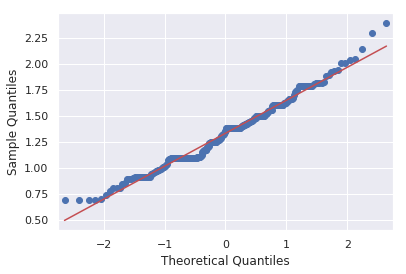

In [6]:
# 再びQ-Qプロットを作図
fig=sm.qqplot(data['Tip'], line='s')

# 欠損値の扱い方

何かデータを入手した際、一部のデータが欠けてしまっているということは、よくあります。このような欠損値を含むデータを解析する場合、そのままモデルに入れてしまうとエラーが発生してしまい、うまく解析できません。対処方法は2つあります。

**欠損値を含むデータを削除する**

一番簡単な方法は、そのデータを削除して揃っているデータだけを活用することです。しかし、あまりにも欠損値が多い場合には貴重なデータを多数失ってしまうことになります。

**欠損値を埋める**

貴重なデータを活用するためには、欠損値を埋める必要があります。「欠損値をとりあえず0で埋める」というのは良い方法ではありません。本当に0であればもちろん問題ないのですが、0ではないものに0という意味のある数値を入れてしまうとデータを汚染してしまうことになります。主な埋め方は、このあと説明する2通りです。何れにしても、まずはどこに欠損値があるのかを確認する必要があります。



In [7]:
# データの中に欠損値があるかどうかを見ます axisが0なのは列を検索するからです。
data.isnull().any(axis=0)

Total_bill     True
Tip           False
Sex           False
Smoker        False
Day           False
Time          False
Size          False
Tax            True
dtype: bool

In [8]:
# 他の調べ方として、各列に含まれる空白の数を調べて表示します。
col_names= data.columns
for col_name in col_names:
    missing_num = sum(pd.isnull(data[col_name]))
    print(col_name, missing_num)

Total_bill 4
Tip 0
Sex 0
Smoker 0
Day 0
Time 0
Size 0
Tax 5


In [9]:
# Qiitaに載っていたもっとシンプルなコード
data.isnull().sum()

Total_bill    4
Tip           0
Sex           0
Smoker        0
Day           0
Time          0
Size          0
Tax           5
dtype: int64

Total_billとTaxに欠損値が存在しているようです。今回は、それぞれ別の方法で欠損値を埋めてみます。

# 方法1：中央値で埋める

下記グラフを確認すると、顧客グループのサイズによってTotal_billは変わりそうだとわかります。

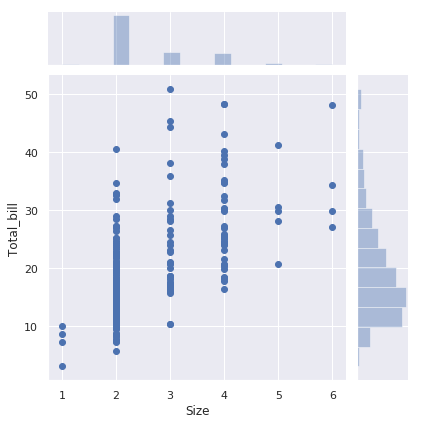

In [10]:
sns.jointplot(data['Size'],data['Total_bill'])

顧客のグループのサイズ(人数）ごとにTotal_billの中央値を割り出し、この値で欠損値を埋めてみましょう。

In [11]:
# 顧客のサイズ（人数）ごとに、Total_billの中央値を割り出します。

data.groupby('Size')['Total_bill'].median()

Size
1     7.915
2    15.370
3    20.365
4    25.890
5    29.850
6    32.050
Name: Total_bill, dtype: float64

In [12]:
# この値をTotal_billが空白となっているセルに入れます。

data['Total_bill'] = data.groupby('Size')['Total_bill'].transform(lambda x: x.fillna(x.median()))

# transform() 変換式を使ってデータ変換を実行する

### lambda(無名関数) とは
***

`lambda 引数: 返り値`

という形で書きます。
短く書いているだけですので、無名ではなくする(関数を定義する)と

`def func(引数):
     return 返り値`

となります。上記のlambda式と、関数funcは同じ実行をします。　つまり

`def return_twice(n):
     return n * 2`
は

`lambda n: n * 2`

となります。

あるいは、引数をつけずに実行することも可能です。

`lambda: random.rand()`

また、引数を複数用いることもできますし、可変長引数やキーワード引数の受付も可能です。

`f = lambda x, *args,  rival,**kwargs: [rival, args, kwargs]
 f(1, 2, 3, rival="ruby", name="python", author="Guido")`
     # ['ruby', (2, 3), {'name': 'python', 'author': 'Guido'}]`

すごく簡単ですよね。

# 方法2：相関のある変数を見つけ出して回帰分析により予測して埋める

下記グラフのように、変数同士に相関がある場合、単回帰分析を実施し欠損値を埋めることができます。

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


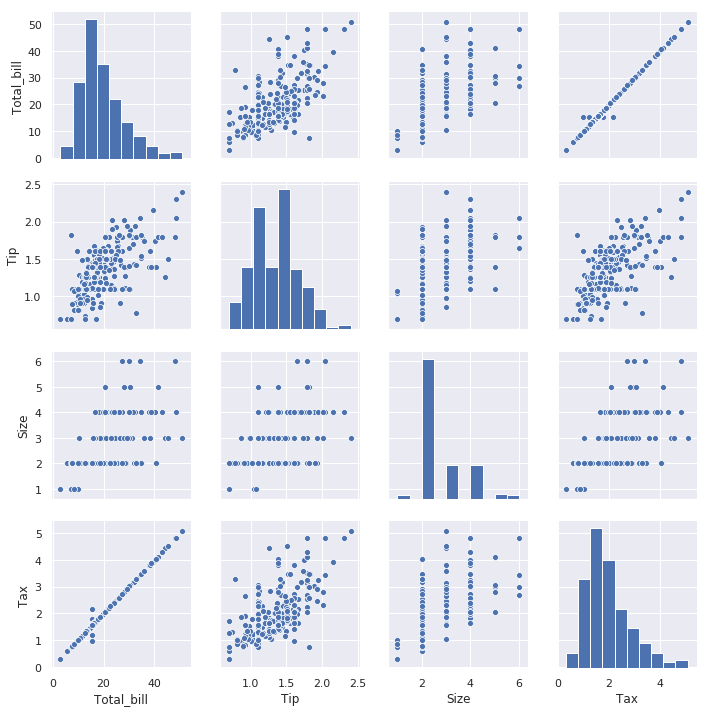

In [13]:
sns.pairplot(data)

欠損値のあるTaxは、Total_billとの相関がハッキリ見えます。単回帰分析で予測して埋めてみましょう。


In [16]:
# 説明変数：Total_billl, 応答変数：Tax で線形モデルを作成
lm= smf.ols(formula='Tax ~ Total_bill', data=data).fit()

# Taxが空白になっているセルに予測した値を入力
data['Tax'].fillna(lm.predict(data['Total_bill']))

0      1.699000
1      1.034000
2      2.101000
3      2.368000
4      2.459000
5      2.528878
6      0.877000
7      2.688000
8      1.504000
9      1.478000
10     1.027000
11     3.526000
12     1.542000
13     1.843000
14     1.483000
15     2.158000
16     1.033000
17     1.629000
18     1.697000
19     2.065000
20     1.792000
21     2.029000
22     1.577000
23     3.942000
24     1.982000
25     1.781000
26     1.337000
27     1.269000
28     2.170000
29     1.965000
         ...   
214    2.817000
215    1.290000
216    2.815000
217    1.159000
218    0.774000
219    3.014000
220    1.216000
221    1.342000
222    0.858000
223    1.598000
224    1.342000
225    1.627000
226    1.009000
227    2.045000
228    1.328000
229    2.212000
230    2.401000
231    1.569000
232    1.161000
233    1.077000
234    1.553000
235    1.007000
236    1.260000
237    3.283000
238    3.583000
239    2.903000
240    2.718000
241    2.267000
242    1.782000
243    1.878000
Name: Tax, Length: 244, 

これで全ての欠損値を埋めることができました。

# 相関のある変数の取り扱い

線形モデルを作成する際、説明変数同士に相関が強いものが含まれると下記のような問題を引き起こすことが知られています。

1.分析結果における係数の標準誤差が大きくなる
2.t値が小さくなる
3.決定係数が大きな値となる
4.回帰係数の符号が本来なるべきものとは逆の符号となる

これを**多重性共線性**といいます。

このような問題を避けるには、**相関関係が高い係数のうち、どちらか一方を説明変数から外す**必要があります。
よくある手法では、相関行列を計算し、そこから相関係数が0.8以上などの強い相関が見られる変数を探し出す方法です。相関行列は対称行列ですので、上三角行列だけ調べてそこから相関係数が0.8以上となる変数を用意します。

In [21]:
#'0.8'という値を持つ変数を作成 threshold=敷居、閾値
threshold=0.8

dataから相関行列 (Correlation Matrix) を作成して表示します。絶対値をとるabs()を適用して、相関係数の値を全て正の値にしています。

In [23]:
corr_matrix =data.corr().abs()
corr_matrix.head()

,Total_bill,Tip,Size,Tax
Total_bill,1.000000,0.655650,0.599628,0.997705
Tip,0.655650,1.000000,0.488512,0.664554
Size,0.599628,0.488512,1.000000,0.603125
Tax,0.997705,0.664554,0.603125,1.000000


In [26]:
upper= corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                 k=1)
                         .astype(np.bool))
upper.head()

,Total_bill,Tip,Size,Tax
Total_bill,NaN,0.65565,0.599628,0.997705
Tip,NaN,NaN,0.488512,0.664554
Size,NaN,NaN,NaN,0.603125
Tax,NaN,NaN,NaN,NaN


上三角行列からtip以外の列についてthreshold以上の値が一つ以上ある列を抽出し、to_dropへ格納します。

In [28]:
to_drop = [column for column in upper.columns
            if column != 'Tip' 
            if any(upper[column] > threshold)]

# any() いずれかの要素がTrueか判定
# all() すべての要素がTrueか判定
# sum() Trueの要素数を返す　（True=1,False=0として処理されることを生かして）

他の説明変数との相関が強い説明変数を判定します。

In [29]:
print('削除する変数：', to_drop)
print('削除する変数の数：', len(to_drop))

削除する変数： ['Tax']
削除する変数の数： 1


dataから削除する変数を削除し、そのデータフレームをdata_droppedとします

In [31]:
data_dropped = data.drop(columns= to_drop)
data_dropped.head()

,Total_bill,Tip,Sex,Smoker,Day,Time,Size
0,16.99,0.698135,Female,No,Sun,Dinner,2
1,10.34,0.978326,Male,No,Sun,Dinner,3
2,21.01,1.504077,Male,No,Sun,Dinner,3
3,23.68,1.460938,Male,No,Sun,Dinner,2
4,24.59,1.528228,Female,No,Sun,Dinner,4


Taxの列が削除されましたね。これで多重共線性の問題を解決できました。

# ダミー変数

変数に数字ではない値（月曜日、火曜日、水曜日、…など）が含まれる変数を、カテゴリ型の変数といいます。このままでは線形モデルに組み込むことができないので、これを0と1だけの数値データへ変換します。月曜日は1、火曜日は2…と置き換えてしまうのは良い方法とは言えません。このように置き換えると日曜日は7になり、まるで月曜日と日曜日に大きな差があるかのような表現になってしまいます。「曜日」という1つの変数を「月曜日」「火曜日」「水曜日」…という7つの変数に分解し、月曜日であれば月曜日の変数が1、他の6つの変数は0とすることで「月曜日」を表現します。これがダミー変数です。

基本的に、カテゴリ型の変数を扱う際にはダミー変数化が必要です。Lesson13.csvのデータでは、男性/女性、喫煙/非喫煙などの情報はカテゴリ変数になりますので、ダミー変数化が必要です。1つずつダミー変数化することも可能ですが、ここでは一度に全てのカテゴリ変数をダミー変数化してしまいましょう。

In [32]:
data_dummied= pd.get_dummies(data_dropped)
data_dummied.head()

,Total_bill,Tip,Size,Sex_Female,Sex_Male,Smoker_No,Smoker_Yes,Day_Fri,Day_Sat,Day_Sun,Day_Thur,Time_Dinner,Time_Lunch
0,16.99,0.698135,2,1,0,1,0,0,0,1,0,1,0
1,10.34,0.978326,3,0,1,1,0,0,0,1,0,1,0
2,21.01,1.504077,3,0,1,1,0,0,0,1,0,1,0
3,23.68,1.460938,2,0,1,1,0,0,0,1,0,1,0
4,24.59,1.528228,4,1,0,1,0,0,0,1,0,1,0


*Pythonでstatsmodelsを用いてモデルを作成する場合には、pd.get_dummies()でダミー変数化することなく変数を扱うことが可能です。

# 訓練データとテストデータ

訓練データとはパラメータの推定に用いるデータ
テストデータとは予測値との誤差を評価するためのデータです。（パラメータの推定に使っていないデータ）

訓練データはパラメータの推定に使っていますので、当てはめ精度を確認することは可能ですが、汎化誤差（まだ手に入れていないデータに対する誤差）を評価することはできません。誤差を評価するためにはパラメータの推定に使用していない、手付かずのデータが必要になります。

通常、用意したデータを9：1から7：3くらいの比率で分割して、訓練データとテストデータにします。

scikit-learnにはtrain_test_splitという便利なデータ分割の関数が用意されていますので、これを使用します。

In [36]:
# DataFrameから説明変数と応答変数を抜き出す
X = data_dummied.drop(columns= ['Tip'])
y = data_dummied['Tip']

train_test_split関数を用いて、訓練データ:テストデータ=7：3に分けます。乱数の再現性を確保するため、random_stateを設定していますが数値は何でも構いません。

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=2)

In [41]:
X_train

,Total_bill,Size,Sex_Female,Sex_Male,Smoker_No,Smoker_Yes,Day_Fri,Day_Sat,Day_Sun,Day_Thur,Time_Dinner,Time_Lunch
127,14.52,2,1,0,1,0,0,0,0,1,0,1
112,38.07,3,0,1,1,0,0,0,1,0,1,0
9,14.78,2,0,1,1,0,0,0,1,0,1,0
90,28.97,2,0,1,0,1,1,0,0,0,1,0
240,27.18,2,1,0,0,1,0,1,0,0,1,0
45,18.29,2,0,1,1,0,0,0,1,0,1,0
91,22.49,2,0,1,1,0,1,0,0,0,1,0
166,20.76,2,0,1,1,0,0,0,1,0,1,0
239,29.03,3,0,1,1,0,0,1,0,0,1,0
175,32.90,2,0,1,0,1,0,0,1,0,1,0


In [42]:
X_test

,Total_bill,Size,Sex_Female,Sex_Male,Smoker_No,Smoker_Yes,Day_Fri,Day_Sat,Day_Sun,Day_Thur,Time_Dinner,Time_Lunch
85,34.83,4,1,0,1,0,0,0,0,1,0,1
54,25.56,4,0,1,1,0,0,0,1,0,1,0
126,8.52,2,0,1,1,0,0,0,0,1,0,1
93,16.32,2,1,0,0,1,1,0,0,0,1,0
113,23.95,2,0,1,1,0,0,0,1,0,1,0
141,34.30,6,0,1,1,0,0,0,0,1,0,1
53,9.94,2,0,1,1,0,0,0,1,0,1,0
65,20.08,3,0,1,1,0,0,1,0,0,1,0
157,25.00,4,1,0,1,0,0,0,1,0,1,0
212,48.33,4,0,1,1,0,0,1,0,0,1,0


# （参考）クロスバリデーション

入手したデータを「訓練データ: テストデータ=7:3」に分けただけですと、本当に推定されたパラメータがこのデータに相応しいかどうかわかりません。もしかするとデータに偏りがあり、うまくこのデータを表現するようなパラメータが得られない可能性はあります。この問題を解決する方法がクロスバリデーション(CV)です。クロスバリデーションには数通りの方法がありますが、ここでは代表的なK-fold CVについて説明します。

K-fold CVでは、まずデータセットをk個のグループに分け、以下のように訓練データとテストデータを定義します。

**クロスバリデーションのテストデータと訓練データ**
>(1) 最初のグループをテストデータ、それ以外のグループを訓練データとする  
>(2) 2つ目のグループをテストデータ、それ以外のグループを訓練データとする  
>...  
>(k) k個目のグループをテストデータ、それ以外のグループを訓練データとする

上記のように定義した上で、それぞれの精度を検証し、最終的にこれらk個の精度の平均をこのデータの精度として評価する方法です。下記の図はデータセットを5つに分けていますので、5-fold CVとなります。

# 過学習とRidge回帰・Lasso回帰

訓練データはとてもよくデータに当てはまっているのに、テストデータで汎化誤差を確認するとあまり精度が良くないということがあります。これはモデルが「手持ちのデータ」に特化しすぎてしまったため、不必要な誤差までも組み込んでしまったことが原因です。この状態を過学習といいます。

たとえば、下図（上）のように、赤い2つのデータを訓練データ、その他の青のデータをテストデータとして回帰直線を引きます。訓練データの誤差は0ですが、テストデータからは大きな汎化誤差が生じてしまいます。そこで、下図（下）のように「訓練データへ完璧に当てはまる訳ではないが、テストデータでの汎化誤差を小さくできる」回帰直線を引くことを考えます。これがRidge回帰とLasso回帰です。

**1 Ridge回帰**

この過学習を回避する新しい回帰直線では、もちろん訓練データの当てはめ精度は最小二乗法で求めた残差平方和よりも大きくなります。これは「最小二乗法により求められた残差平方和に何か誤差を追加すると、求める回帰直線が得られる」と考えることもできます。

Ridge回帰では、この「追加する誤差」をλ×(傾きα)2乗
としています。
訓練データにおける残差平方和が「最小二乗法により求められた誤差+λ×(傾きα)2乗」となるような直線が過学習を回避する回帰直線ということになります。λの大きさにより、新しい回帰直線が元の直線に比べどのくらい傾くかが決まります。

このλは10-fold CVにより決定します。λの候補を複数用意し、それぞれ10セットずつ汎化誤差を計算し、汎化誤差の平均が最小となるものをλとして選択します。λは0から無限大までの値をとることができます。λ=0ということはλ×(傾きα)2も0となりますので、新しく求める回帰直線は最小二乗法により求めた回帰直線と同じものになります。

ここで、Ridge回帰を実装してみましょう。

In [44]:
# λの候補を50個作成
n_lambda= 50
ridge_lambdas= np.logspace(-10, 1, n_lambda)

In [45]:
# その中から、最適なものを10-fold CV でさがしてモデルを作成
model= RidgeCV(cv=10, 
               alphas=ridge_lambdas, 
               fit_intercept=False)
model.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000e-10, 1.67683e-10, 2.81177e-10, 4.71487e-10, 7.90604e-10,
       1.32571e-09, 2.22300e-09, 3.72759e-09, 6.25055e-09, 1.04811e-08,
       1.75751e-08, 2.94705e-08, 4.94171e-08, 8.28643e-08, 1.38950e-07,
       2.32995e-07, 3.90694e-07, 6.55129e-07, 1.09854e-06, 1.84207e-06,
     ..., 4.49843e-01, 7.54312e-01,
       1.26486e+00, 2.12095e+00, 3.55648e+00, 5.96362e+00, 1.00000e+01]),
    cv=10, fit_intercept=False, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [47]:
# テストデータから予測を行い、汎用誤差を確認
y_pred= model.predict(X_test)
mean_squared_error(y_test, y_pred)

0.042489652509092465

上記の計算結果は平均二乗誤差を求めています。平均二乗誤差は(予測値 - 実際の値)**2をデータ数で割ることで算出できました。
この0.042の平方根を取ると0.2USドル、つまり1件あたり平均で20セントの汎化誤差があるとわかりました。なかなかの予測精度ではないでしょうか。

**2 Lasso回帰**

Lasso回帰はRidge回帰とほぼ同じです。Ridge回帰ではλ×(傾きα) **2を残差平方和に追加しましたが、Lasso回帰ではλ×|傾きα|を追加することになります。